In [1]:
import cv2
import numpy as np
import os
import time
from matplotlib import pyplot as plt
from pyzbar.pyzbar import decode

%matplotlib inline

In [2]:
seq_name = "160317_moonbaby1_with_ground"
data_path = "/home/lei/data/KinectStream/panoptic_captures/"
color_path = os.path.join(data_path, seq_name, "color")
depth_path = os.path.join(data_path, seq_name, "depth")
qr_path = os.path.join(data_path, "qr")

out_color_path = os.path.join(data_path, seq_name, "tiled", "color")
out_depth_path = os.path.join(data_path, seq_name, "tiled", "depth")
os.makedirs(out_color_path, exist_ok=True)
os.makedirs(out_depth_path, exist_ok=True)

In [3]:
def display_image(image):
    plt.figure(figsize = (50,100))
    plt.axis('off')
    if image.ndim == 3 and image.shape[2] == 3:
        plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    elif image.ndim == 3 and image.shape[2] == 4:
        plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGRA2RGBA))
    elif image.ndim == 2:
        plt.imshow(image)
    else:
        raise ValueError("Invalid image shape")
    plt.show()

In [4]:
def add_qr_color(view_img, qr_folder, frame_id, offset_x=20, offset_y=20, add_text=False):
    qr_image = cv2.imread(os.path.join(qr_folder, f"{frame_id}_qrcode.png"), cv2.IMREAD_GRAYSCALE)
    if qr_image is None:
        raise ValueError(f"Cannot find QR code for frame {frame_id}")
    
    h = qr_image.shape[0]
    w = qr_image.shape[1]

    view_img[offset_y:offset_y+h, offset_x:offset_x+w, 0] = qr_image
    view_img[offset_y:offset_y+h, offset_x:offset_x+w, 1] = qr_image
    view_img[offset_y:offset_y+h, offset_x:offset_x+w, 2] = qr_image
    if view_img.shape[2] == 4:
        view_img[offset_y:offset_y+h, offset_x:offset_x+w, 3] = 255

    if add_text:
        text_offset_x = offset_x + w + 200
        text_offset_y = offset_y + h
        cv2.putText(view_img, f"{frame_id}", (text_offset_x, text_offset_y), cv2.FONT_HERSHEY_SIMPLEX, 3.0, (0, 255, 0, 255), 8)
    return view_img

In [5]:
def add_qr_yuv16(dimg_channel_list, qr_folder, frame_id, offset_x=20, offset_y=20, is_scaled=True, add_text=False):
    qr_image = cv2.imread(os.path.join(qr_folder, f"{frame_id}_qrcode.png"), cv2.IMREAD_GRAYSCALE)
    if qr_image is None:
        raise ValueError(f"Cannot find QR code for frame {frame_id}")
    
    h = qr_image.shape[0]
    w = qr_image.shape[1]

    qr_image_float = qr_image.astype(np.float32)
    if is_scaled:
        qr_image_float = (qr_image_float / 255.0) * 65535.0
        qr_image = qr_image_float.astype(np.uint16)
    else:
        qr_image = qr_image.astype(np.uint16)

    dimg_channel_list[1][offset_y:offset_y+h, offset_x:offset_x+w] = qr_image
    dimg_channel_list[2][offset_y:offset_y+h, offset_x:offset_x+w] = qr_image

    if add_text:
        text_offset_x = offset_x + w + 200
        text_offset_y = offset_y + h
        cv2.putText(dimg_channel_list[1], f"{frame_id}", (text_offset_x, text_offset_y), cv2.FONT_HERSHEY_SIMPLEX, 3.0, (0, 65535, 0), 8)
        cv2.putText(dimg_channel_list[2], f"{frame_id}", (text_offset_x, text_offset_y), cv2.FONT_HERSHEY_SIMPLEX, 3.0, (0, 65535, 0), 8)
    return dimg_channel_list

In [7]:
start_frame_id = 1829
end_frame_id = start_frame_id + 1

for frame_id in range(start_frame_id, end_frame_id + 1):
    if frame_id % 100 == 0:
        print(frame_id)
    
    cimg_horizontal0 = []
    cimg_horizontal1 = []

    dimg_horizontal0 = []
    dimg_horizontal1 = []
    for view_id in range(0, 10):
        # Load color image
        color_filename = os.path.join(color_path, f"{frame_id}_color_{view_id}.png")
        color_img = cv2.imread(color_filename, cv2.IMREAD_UNCHANGED)

        if color_img is None:
            print(f"Color image {color_filename} not found")
            break

        if view_id == 0:
            color_img = add_qr_color(color_img, qr_path, frame_id, add_text=True)

        # Load depth image
        depth_filename = os.path.join(depth_path, f"{frame_id}_depth_{view_id}.png")
        depth_img = cv2.imread(depth_filename, cv2.IMREAD_ANYDEPTH)

        if depth_img is None:
            print(f"Depth image {depth_filename} not found")
            break

        if view_id < 5:
            cimg_horizontal0.append(color_img)
            dimg_horizontal0.append(depth_img)
        else:
            cimg_horizontal1.append(color_img)
            dimg_horizontal1.append(depth_img)
    
    cimg_tiled = np.vstack((np.hstack(cimg_horizontal0), np.hstack(cimg_horizontal1)))
    dimg_tiled0 = np.vstack((np.hstack(dimg_horizontal0), np.hstack(dimg_horizontal1)))
    cimg_tiled[:, :, 3] = 255
    
    # Scale depth image
    dimg_tiled0_float = dimg_tiled0.astype(np.float32)
    dimg_tiled0_float = (dimg_tiled0_float / 6000.0) * 65535.0
    dimg_tiled0 = dimg_tiled0_float.astype(np.uint16)

    # Add QR code in 2 other channels
    dimg_tiled1 = np.zeros((dimg_tiled0.shape[0], dimg_tiled0.shape[1]), dtype=np.uint16)
    dimg_tiled1.fill(32768)
    dimg_tiled2 = np.zeros((dimg_tiled0.shape[0], dimg_tiled0.shape[1]), dtype=np.uint16)
    dimg_tiled2.fill(32768)

    dimg_tiled_list = [dimg_tiled0, dimg_tiled1, dimg_tiled2]
    dimg_tiled_list = add_qr_yuv16(dimg_tiled_list, qr_path, frame_id, add_text=True)
    
    while True:
        if(cv2.imwrite(os.path.join(out_color_path, f"{frame_id}_color.png"), cimg_tiled) != True):
            print(f"Failed to write color frame {frame_id}")
            time.sleep(1)
            continue
        
        if(cv2.imwrite(os.path.join(out_depth_path, f"{frame_id}_depth_0.png"), dimg_tiled_list[0]) != True):
            print(f"Failed to write depth frame {frame_id}")
            time.sleep(1)
            continue

        if(cv2.imwrite(os.path.join(out_depth_path, f"{frame_id}_depth_1.png"), dimg_tiled_list[1]) != True):
            print(f"Failed to write depth frame {frame_id}")
            time.sleep(1)
            continue

        if(cv2.imwrite(os.path.join(out_depth_path, f"{frame_id}_depth_2.png"), dimg_tiled_list[2]) != True):
            print(f"Failed to write depth frame {frame_id}")
            time.sleep(1)
            continue
        break
        # cv2.imwrite(os.path.join(out_depth_path, f"{frame_id}_depth_0.png"), dimg_tiled_list[0])
        # cv2.imwrite(os.path.join(out_depth_path, f"{frame_id}_depth_1.png"), dimg_tiled_list[1])
        # cv2.imwrite(os.path.join(out_depth_path, f"{frame_id}_depth_2.png"), dimg_tiled_list[2])

    # display_image(cimg_tiled)
    # display_image(dimg_tiled0)
    # display_image(dimg_tiled1)
    # display_image(dimg_tiled2)

In [25]:
def color_to_buf(cimg, color_format="bgra"):
    if color_format == "rgba":
        cimg = cv2.cvtColor(cimg, cv2.COLOR_BGRA2RGBA)
    elif color_format == "rgb":
        cimg = cv2.cvtColor(cimg, cv2.COLOR_BGRA2RGB)
    elif color_format == "bgr":
        cimg = cv2.cvtColor(cimg, cv2.COLOR_BGRA2BGR)
    elif color_format == "bgra":
        pass
    else:
        raise ValueError("Invalid color format")
    return cimg.tobytes()

def depth_to_buf(dimg_channel_list, depth_format="yuv16"):
    if depth_format == "yuv16":
        buf = dimg_channel_list[0].tobytes() + dimg_channel_list[1].tobytes() + dimg_channel_list[2].tobytes()
    else:
        raise ValueError("Invalid depth format")
    return buf

In [26]:
color_buf = color_to_buf(cimg_tiled)
depth_buf = depth_to_buf(dimg_tiled_list)

In [29]:
assert len(color_buf) == cimg_tiled.shape[0] * cimg_tiled.shape[1] * 4
assert len(depth_buf) == dimg_tiled_list[0].shape[0] * dimg_tiled_list[0].shape[1] * 3 * 2

In [31]:
h = cimg_tiled.shape[0]
w = cimg_tiled.shape[1]
d = 4
cimg_res = np.ndarray(shape=(h, w, d), buffer=color_buf, dtype=np.uint8)

d = 3
dimg_res = np.ndarray(shape=(d, h, w), buffer=depth_buf, dtype=np.uint16)

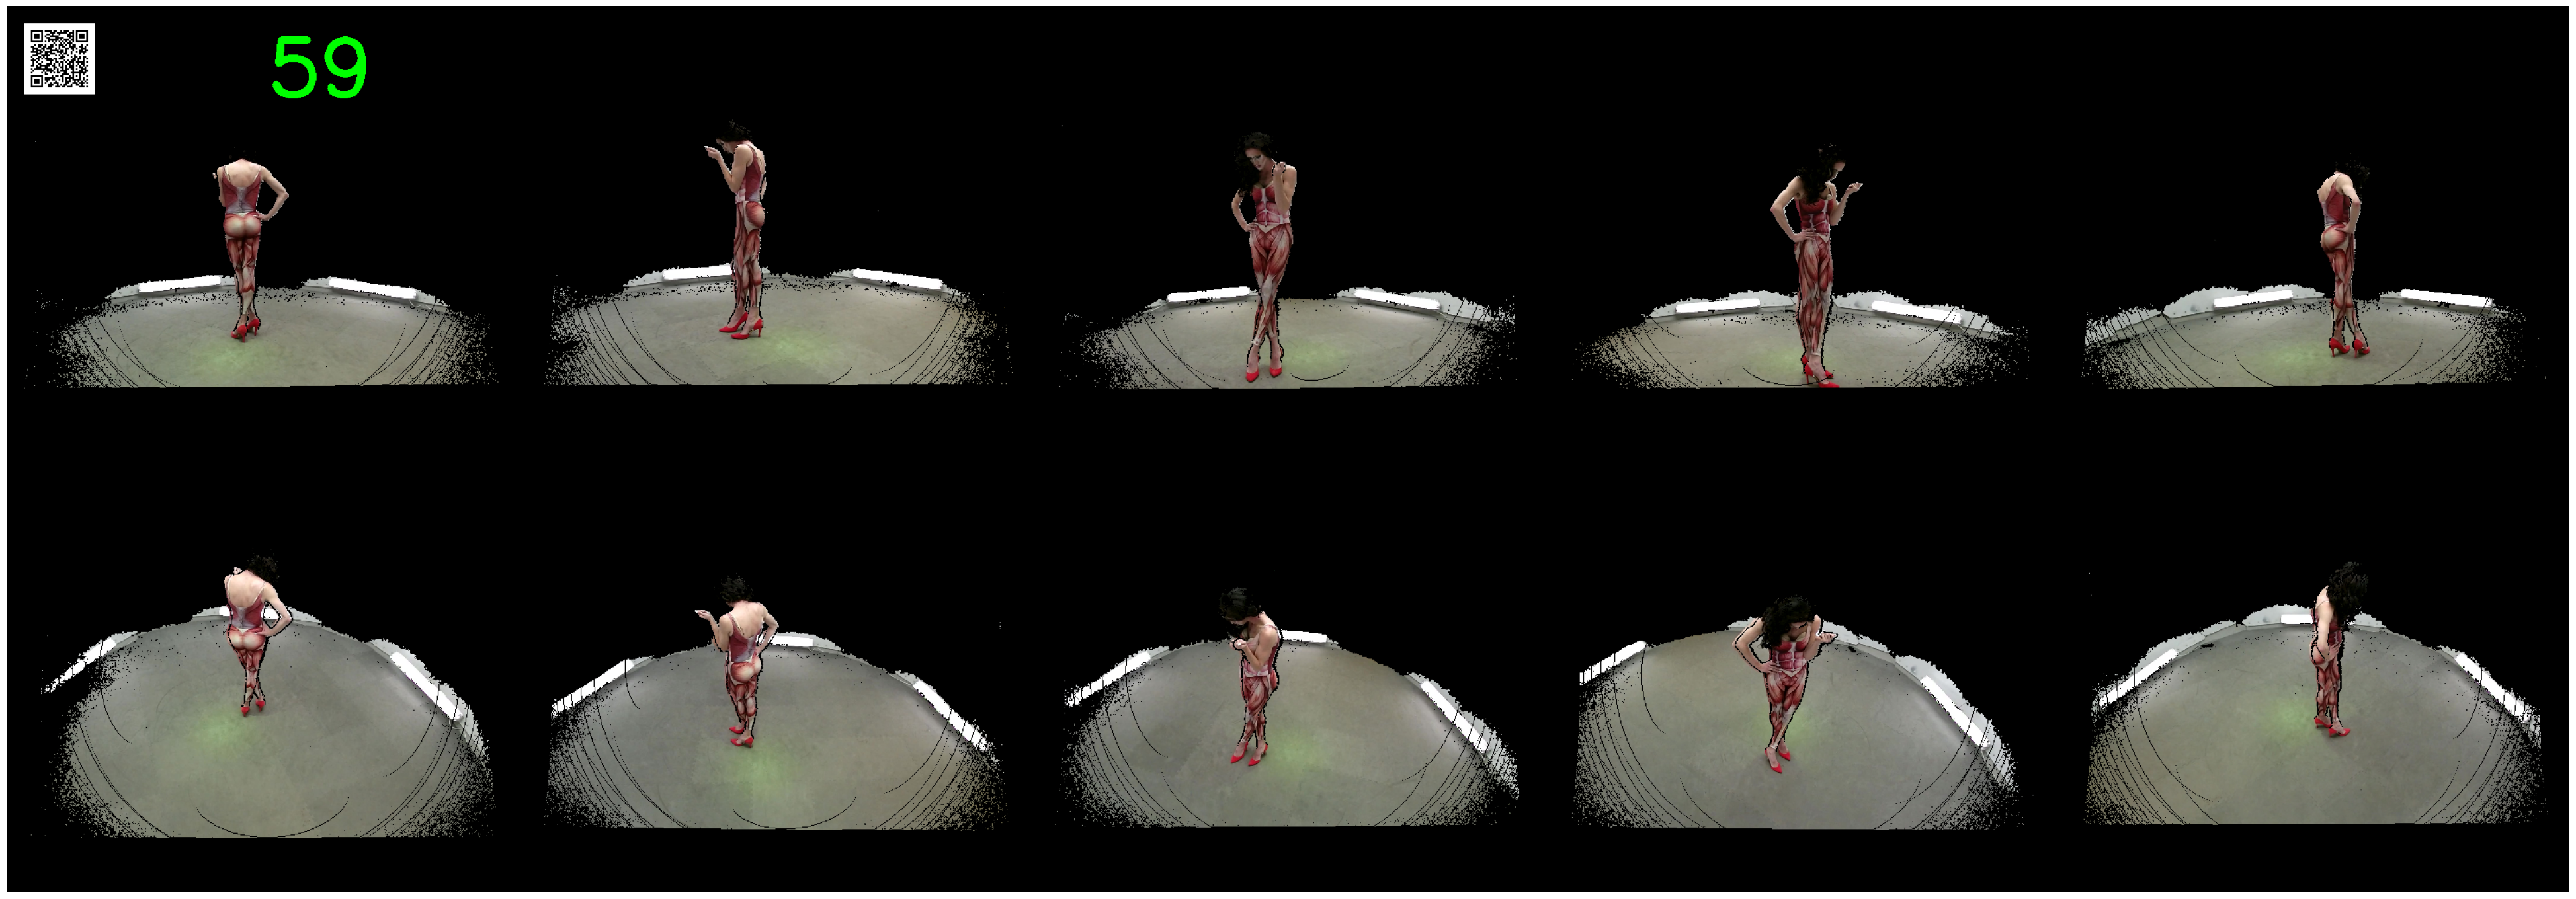

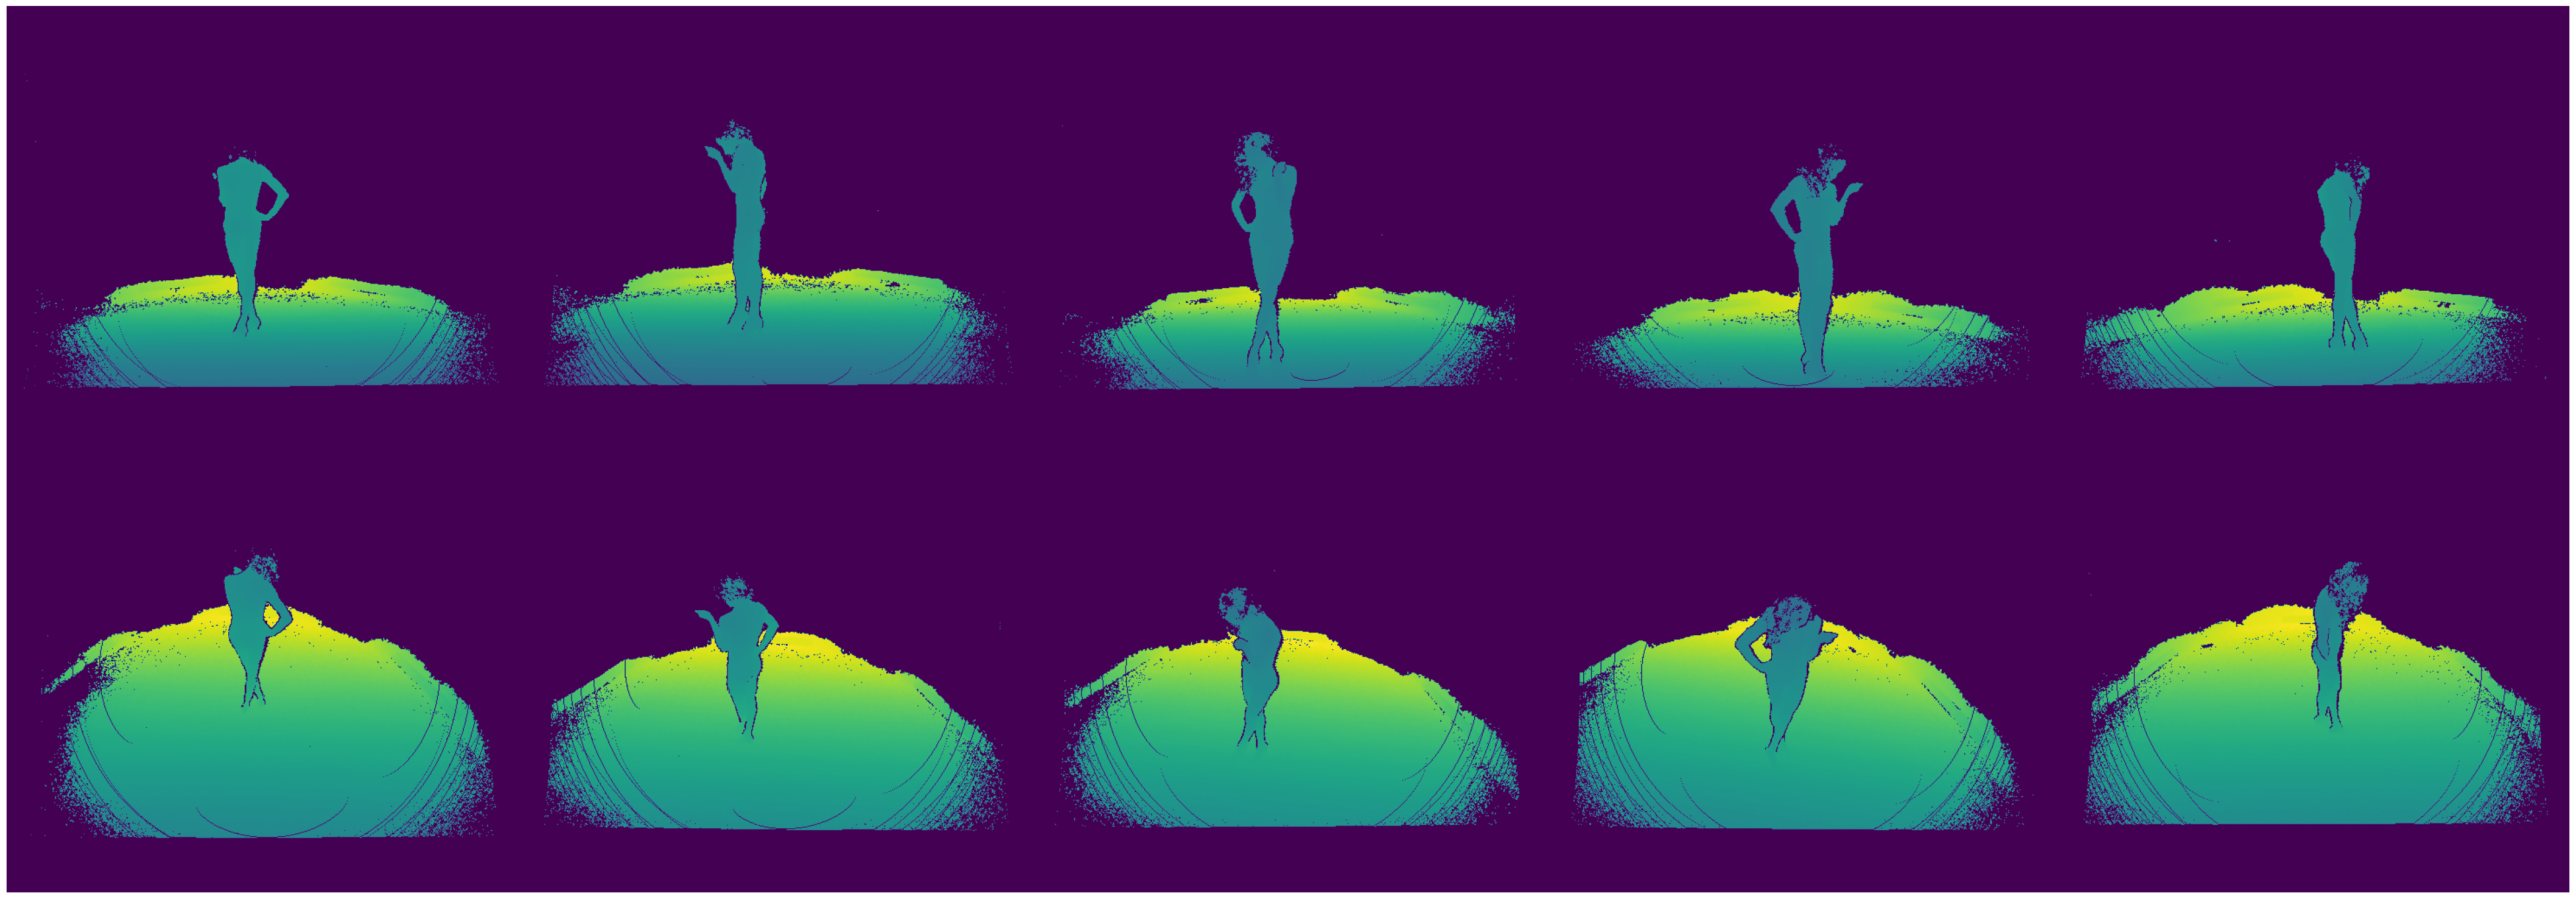

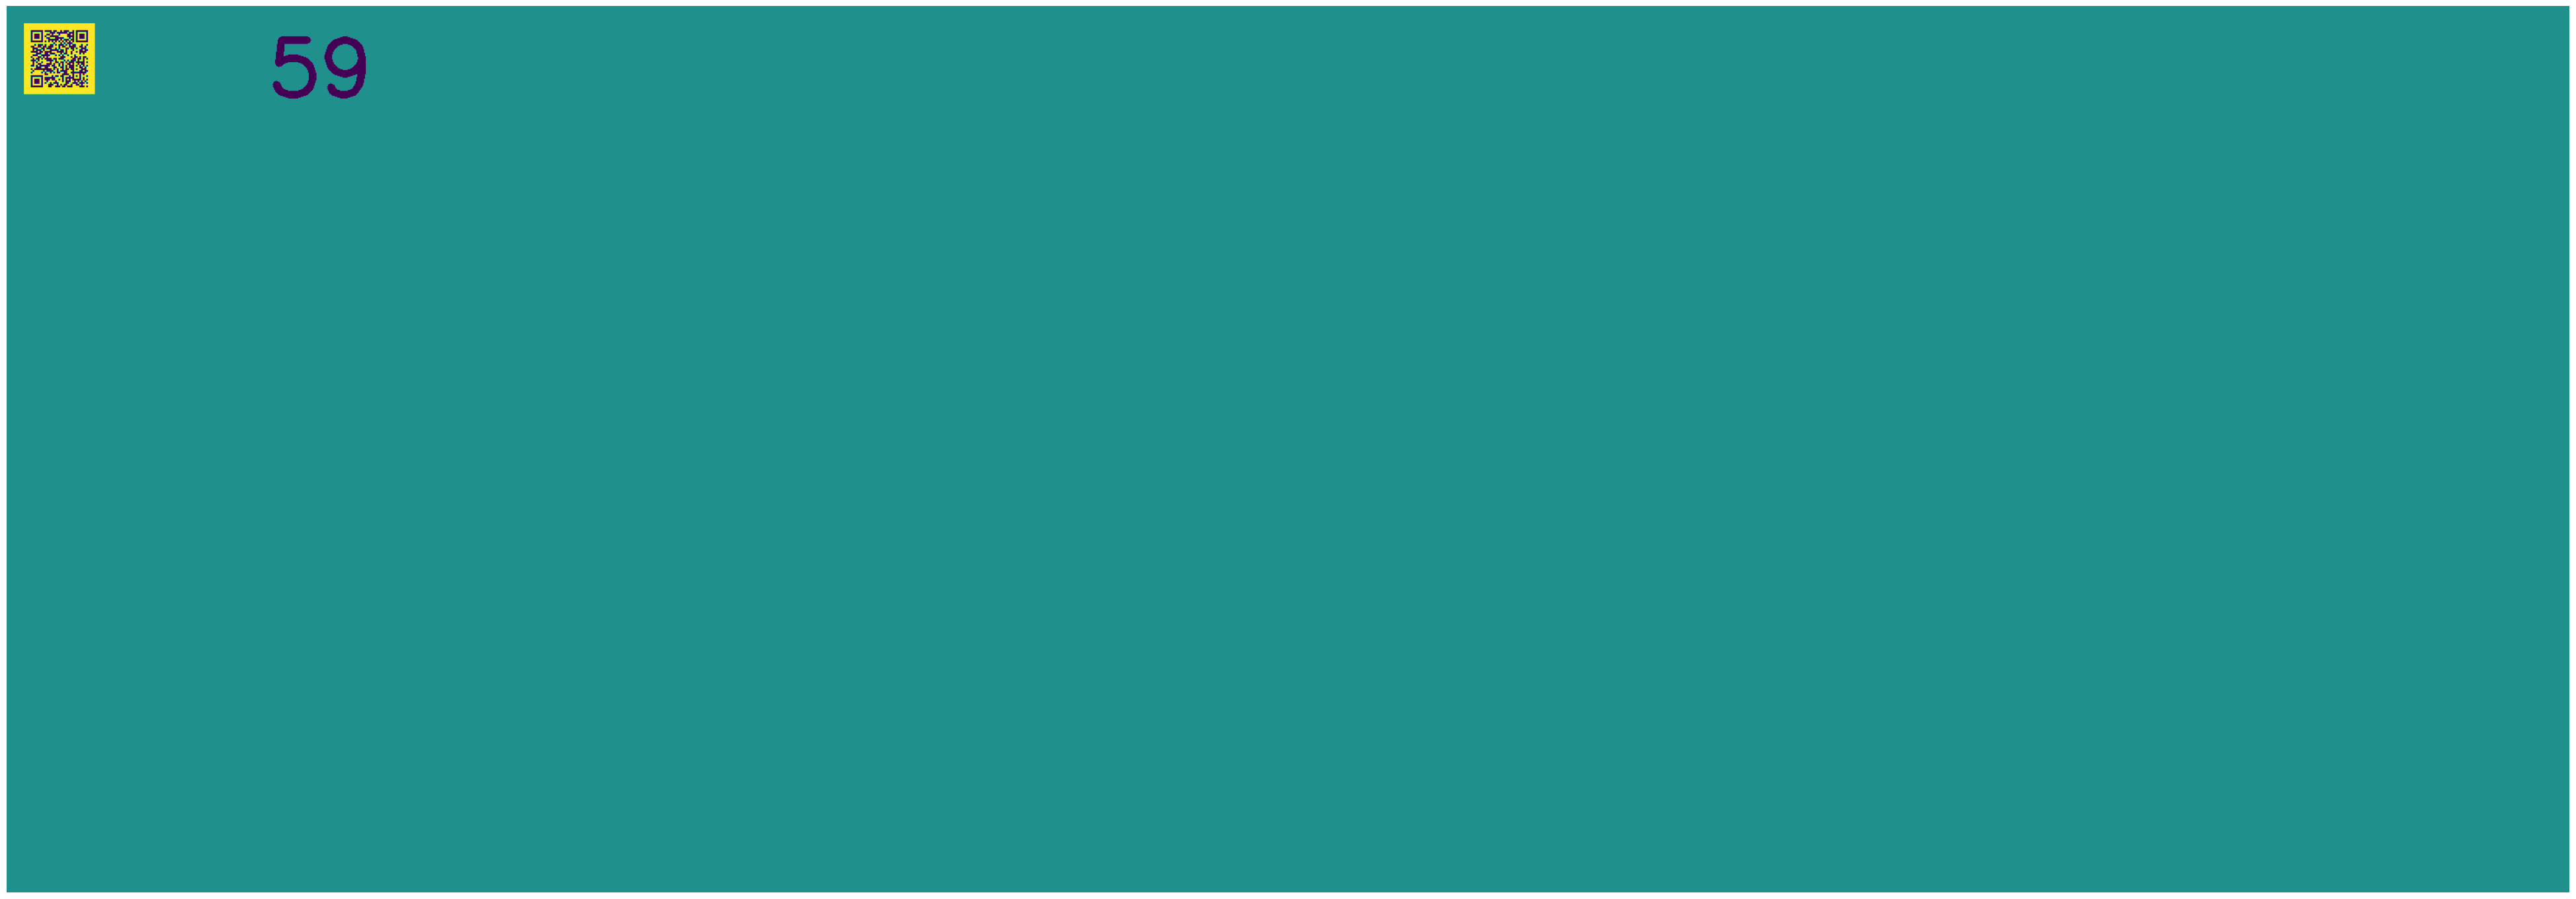

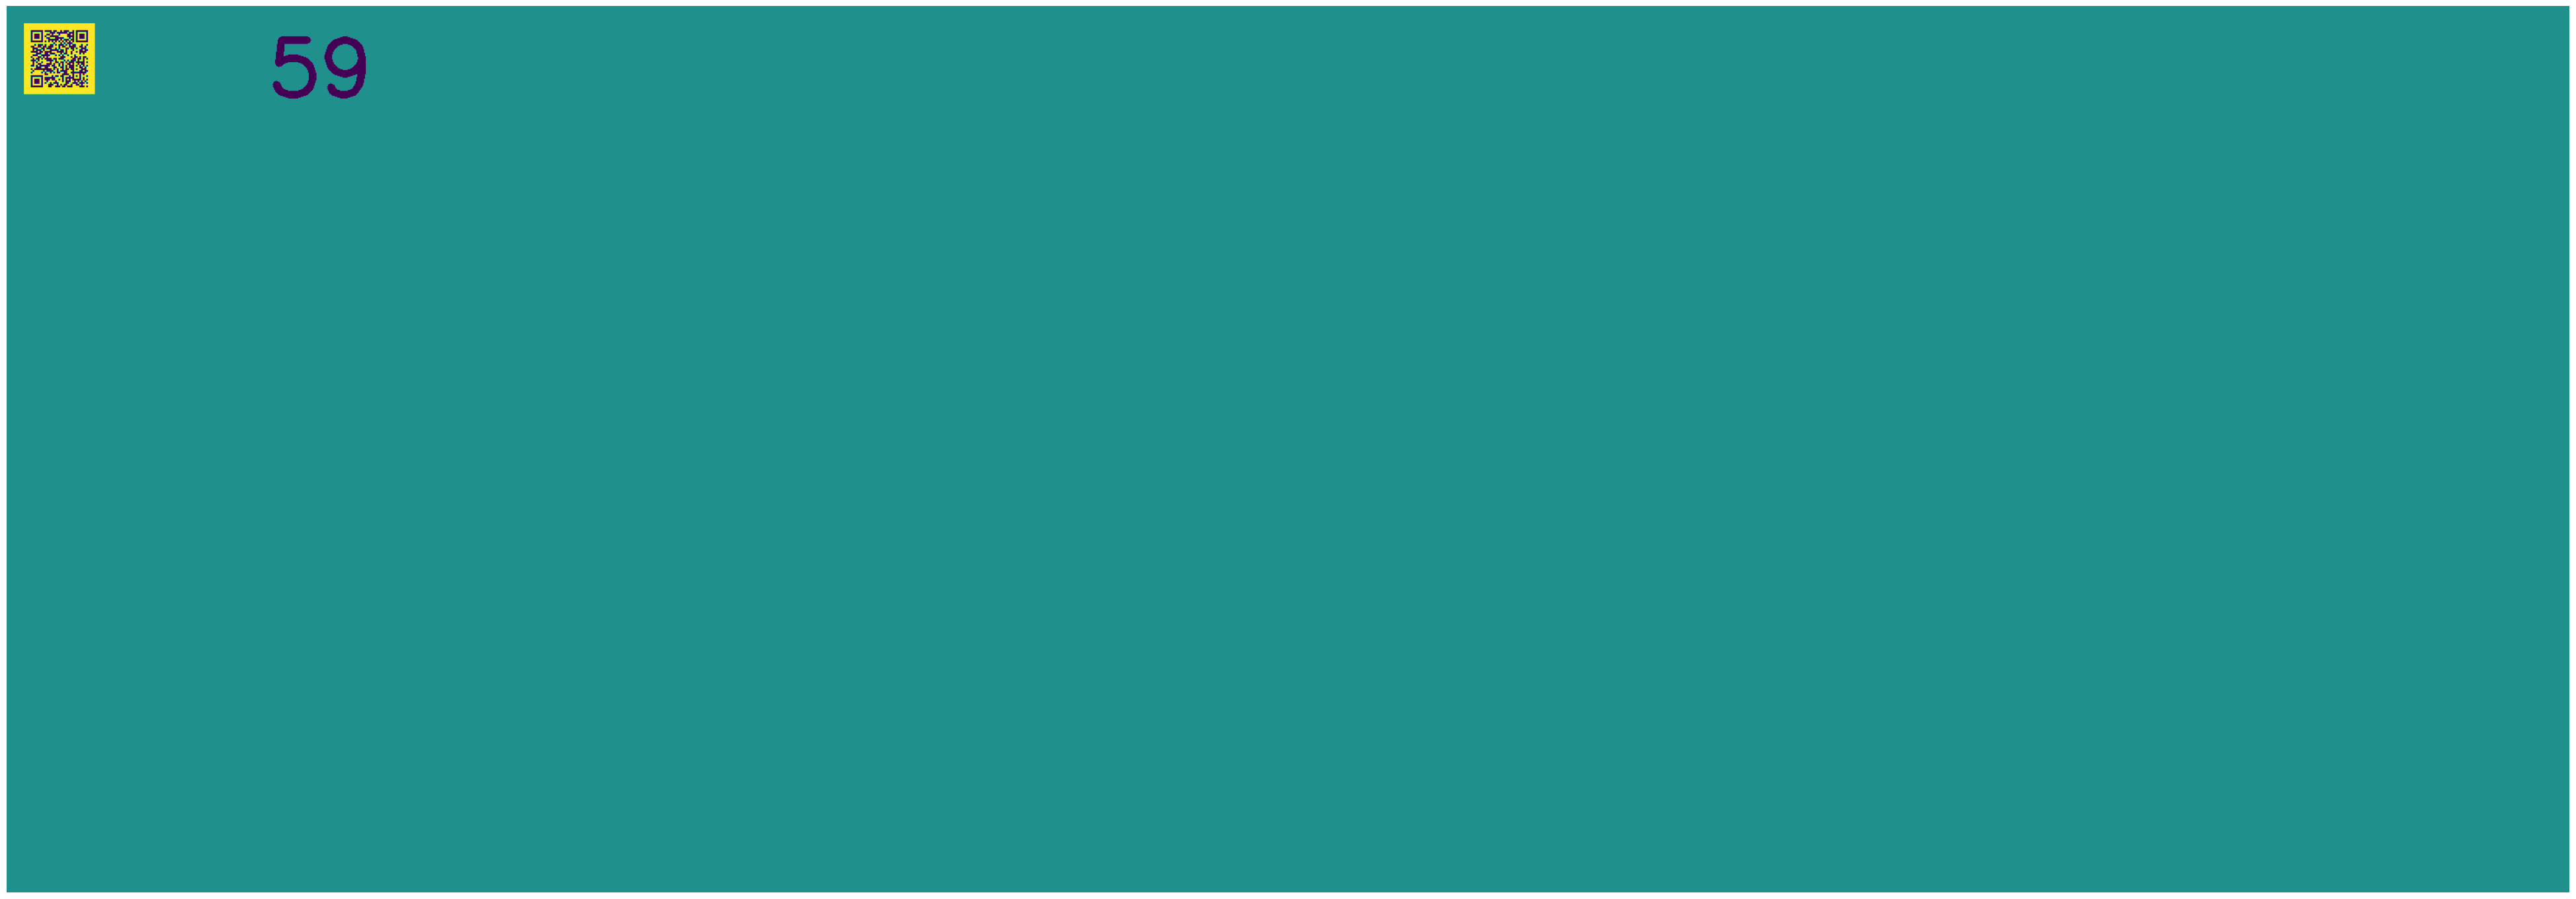

In [32]:
display_image(cimg_res)
display_image(dimg_res[0, :, :])
display_image(dimg_res[1, :, :])
display_image(dimg_res[2, :, :])

In [34]:
def decode_qr_code(image, offset_x=20, offset_y=20, roi_width=82, roi_height=82, view_number=0):
        start_y = view_number // 5 * 512
        start_x = view_number % 5 * 592
        # Extract the region of interest (ROI) based on the offset and size
        roi = np.copy(image[start_y + offset_y:start_y + offset_y+roi_height, start_x + offset_x:start_x + offset_x+roi_width])
        # out_img_path = os.path.join(self.out_dir, f"{self.count}_color_qr.png")
        # cv.imwrite(out_img_path, roi)

        # Convert the ROI to grayscale
        gray_roi = cv2.cvtColor(roi, cv2.COLOR_BGRA2GRAY)

        # Use pyzbar to decode the QR code
        qr_codes = decode(gray_roi)

        if qr_codes:
            # There may be multiple QR codes in the ROI, but we'll handle just the first one for this example
            qr_code_data = qr_codes[0].data.decode('utf-8')
            # print("Decoded QR Code data:", qr_code_data)
            return int(qr_code_data)
        else:
            print("[WebRTCClient, _decode_qr_code()] No QR Code detected in the ROI.")
            return -1
            # mode, _ = stats.mode(image, axis=None)
            # return mode[0]

def decode_qr_code_yuv(image, offset_x=20, offset_y=20, roi_width=82, roi_height=82):
    # Extract the region of interest (ROI) based on the offset and size
    if roi_width and roi_height:
        roi = image[offset_y:offset_y+roi_height, offset_x:offset_x+roi_width]
    else:
        roi = image
    
    # Convert the ROI to grayscale
    # gray_roi = np.copy(roi).astype(np.uint8)
    gray_roi = np.copy(roi).astype(np.float64)
    gray_roi = gray_roi / 65535.0 * 255.0
    gray_roi = gray_roi.astype(np.uint8)

    # Use pyzbar to decode the QR code
    qr_codes = decode(gray_roi)

    if qr_codes:
        # There may be multiple QR codes in the ROI, but we'll handle just the first one for this example
        qr_code_data = qr_codes[0].data.decode('utf-8')
        # print("Decoded QR Code data:", qr_code_data)
        return int(qr_code_data)
    else:
        # print("[WebRTCClient, _decode_qr_code()] No QR Code detected in the ROI.")
        return -1

In [35]:
print(decode_qr_code(cimg_res))
print(decode_qr_code_yuv(dimg_res[1, :, :]))

59
59
